# Solving Helmholtz equation with PINNs

In [1]:
from matplotlib import pyplot as plt

from jwave.geometry import Domain
from jwave import operators as jops
from jwave.core import operator
from jax import numpy as jnp
import jax

The equation we want to simulate is

$$
\left(\nabla^2 - \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfield radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\|x_j - \Delta_{PML}\|^\alpha}{\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}$$

Let's start by building up the $\sigma$ function

In [18]:
domain = Domain((256, 256), (1., 1.))
omega = .2

In [3]:
from jwave.discretization import Coordinate
from jwave.core import Field

coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="X")

# Define PML Function
delta_pml = 100.
def sigma(X):
    on_pml = jops.elementwise(
        lambda x: jnp.where(
            jnp.abs(x) > delta_pml,
            (jnp.abs(jnp.abs(x)-delta_pml)/(128. - delta_pml)), 
            0.)
    )
    return 4.*on_pml(X)**2

def pml_factor(X):
    return 1./(1 + 1j*sigma(X)/omega)

# Define laplacian with PML
def laplacian(u, x):
    pml = pml_factor(x)
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    return jops.sum_over_dims(mod_diag_jacobian)

@operator()
def helmholtz(u, c, x):
    # Get the modified laplacian
    L = laplacian(u, x)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u
    
    return L + k

In [4]:
from jwave.discretization import Arbitrary, UniformField
from jax.experimental import stax
from jax import random

seed = random.PRNGKey(42)

# Make a neural network for the field discretization
Sin = stax.elementwise(jnp.sin)
init_random_params, predict = stax.serial(
    stax.Dense(512), 
    Sin, 
    stax.Dense(512), 
    Sin, 
    stax.Dense(512), 
    Sin, 
    stax.Dense(512), 
    Sin, 
    stax.Dense(512), 
    Sin, 
    stax.Dense(1)
)

def init_params(seed, domain):
    return init_random_params(seed, (len(domain.N),))[1]

def get_fun(params, x):
    x = x/64.
    p = predict(params, x)
    return p

u_discr = Arbitrary(domain, get_fun, init_params)
u_params, u = u_discr.random_field(seed, name='u')

# Narrow gaussian pulse as source
def init_params(seed, domain):
    return {}

def gaussian_func(params, x):
    x = x + jnp.asarray([50,50])
    return jnp.expand_dims(jnp.exp(-jnp.sum(x**2)/16) + 0*1j, -1)

src_discr = Arbitrary(domain, gaussian_func, init_params)
src_params, src = src_discr.random_field(seed, name='src')

# Arbitrary Speed of Sound map
def init_params(seed, domain):
    return {}

def sos_func(params, x):
    x = x - jnp.asarray([32,32])
    x = jnp.exp(-jnp.sum(x**2)/2048)
    x = jnp.where(jnp.abs(x)>0.5, 1., 0.)
    return jnp.expand_dims(x + 1., -1)
                  
c_discr = Arbitrary(domain, sos_func, init_params)
c_params, c = c_discr.random_field(seed, name='c')

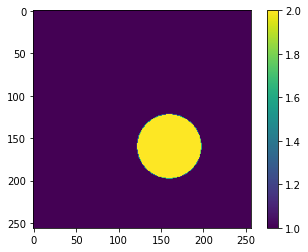

In [5]:
sos_map = c_discr.get_field_on_grid()({})
plt.imshow(sos_map)
plt.colorbar()

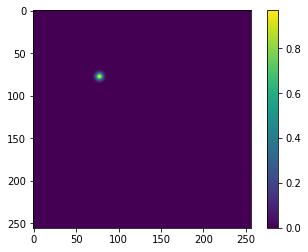

In [6]:
src_map = src_discr.get_field_on_grid()({})
plt.imshow(src_map.real)
plt.colorbar()

In [7]:
Hu = helmholtz(u=u, c=c, x=X)
global_params = Hu.get_global_params()

In [8]:
f = Hu.get_field(0)

In [9]:
x = jnp.asarray([2.,2.])
f(global_params,{"u": u_params, "c":c_params, "x":{}}, x)

DeviceArray([0.00104617+0.j], dtype=complex64)

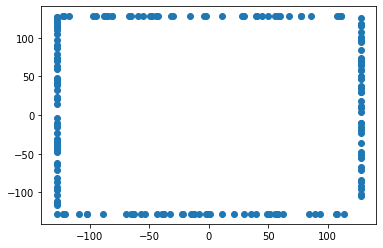

In [10]:
boundary_sampler = domain.boundary_sampler
x = boundary_sampler(seed, 200)
plt.scatter(x[:,0],x[:,1])

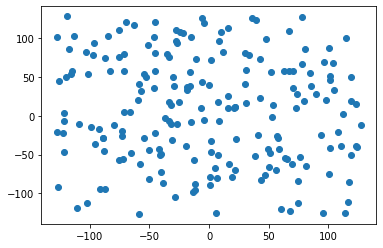

In [11]:
domain_sampler = domain.domain_sampler()
x = domain_sampler(seed, 200)
plt.scatter(x[:,0],x[:,1])

In [12]:
from jax import value_and_grad

f = Hu.get_field(0)
def helmholtz_fun(params, x):
    return f(global_params,{"u": params, "c":c_params, "x":{}}, x)

# Defining losses
field = u_discr.get_field()
source_f = src.get_field()
def boundary_loss(params, seed, batchsize):
    x = boundary_sampler(seed, batchsize)
    field_val = jax.vmap(field, in_axes=(None,0))(params,x)
    return jnp.sum(jnp.abs(field_val)**2)

def domain_loss(params, seed, batchsize):
    x = domain_sampler(seed, batchsize)
    helm_val = jax.vmap(helmholtz_fun, in_axes=(None,0))(params,x)
    src_val = jax.vmap(source_f, in_axes=(None,0))(None, x)
    return jnp.sum(jnp.abs(src_val + helm_val)**2)

bound_valandgrad = value_and_grad(boundary_loss)
domain_valandgrad = value_and_grad(domain_loss)

In [13]:
import wandb

In [14]:
from jax.experimental import optimizers
from jax.tree_util import tree_multimap
from jax import jit
from tqdm import tqdm

losshistory = []
batch_size = 512

init_fun, update_fun, get_params = optimizers.adam(.0001, b1=0.9, b2=0.99)
opt_state = init_fun(u_params)

@jit
def update(opt_state, seed, k):
    params = get_params(opt_state)
    seeds = random.split(seed, 2)
    
    # losses
    boundary_loss, b_gradient = bound_valandgrad(params, seeds[0], batch_size)
    domain_loss, d_gradient = domain_valandgrad(params, seeds[1], batch_size)
    gradient = tree_multimap(lambda x,y: 0.01*x+y, b_gradient, d_gradient)
    
    return boundary_loss, domain_loss, update_fun(k, gradient, opt_state)

pbar = tqdm(range(100000))
tol = 1e-3
rng = seed

wandb.init(project="helmholtz-pinn")

boundary_loss_h = 0.
domain_loss_h = 0.
for k in pbar:
    rng, seed = random.split(rng,2)
    boundary_loss, domain_loss, opt_state = update(opt_state, seed, k)
    losshistory.append(domain_loss)

    # For logging
    boundary_loss_h = boundary_loss_h + boundary_loss
    domain_loss_h = domain_loss_h + domain_loss
    if (k+1) % 200 == 0:
        boundary_loss_h = boundary_loss_h / 200.
        domain_loss_h = domain_loss_h / 200.
        wandb.log({'boundary_loss': boundary_loss_h, 'domain_loss': domain_loss_h}, step=k)
        pbar.set_description("B: {:01.4f} | D: {:01.4f}".format(
            jnp.log10(boundary_loss), 
            jnp.log10(domain_loss)
        ))
        boundary_loss_h = 0.
        domain_loss_h = 0.


  0%|                                                              | 0/100000 [00:00<?, ?it/s]wandb: Currently logged in as: rpfeynman (use `wandb login --relogin` to force relogin)
/home/antonios/anaconda3/envs/jwave/lib/python3.8/site-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


B: -1.5298 | D: -1.9712: 100%|███████████████████████| 100000/100000 [14:55<00:00, 111.62it/s]


In [15]:
f_grid = u_discr.get_field_on_grid()

In [16]:
V = f_grid(get_params(opt_state))

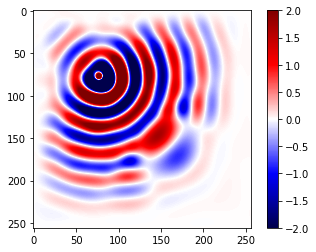

In [19]:
plt.imshow(V[...,0].real, cmap="seismic", vmin=-2, vmax=2)
plt.colorbar()

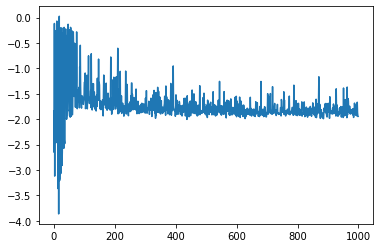

In [21]:
plt.plot(jnp.log10(jnp.asarray(losshistory)[::100]))